# Visualize model predictions vs labels

In [1]:
import sys, os
sys.path.append('..')
os.chdir('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from emonet.models import EmoNet
from emonet.data import EmoNetCSV

In [3]:
# Canonical class orders used by EmoNet expression head.
CANONICAL_8 = ["neutral","happy","sad","surprise","fear","disgust","anger","contempt"]
CANONICAL_5 = ["neutral","happy","sad","surprise","fear"] 

def build_fixed_label_map(nclasses: int):
    if nclasses == 8:   order = CANONICAL_8
    elif nclasses == 5: order = CANONICAL_5
    else:               raise ValueError("nclasses must be 5 or 8")
    return { name: i for i, name in enumerate(order) }

def get_dataset_label2id(csv: str|Path, n: int=8) -> dict|None:
    df_train = pd.read_csv(str(csv))
    label2id = None
    label2id = build_fixed_label_map(n)
    # sanity-check dataset labels
    seen = set(df_train["label"].astype(str).str.strip().str.lower().unique())
    expected = set(label2id.keys())
    unknown = seen - expected
    if unknown:
        raise ValueError(
            f"Unknown labels in CSV: {sorted(unknown)}. "
            f"Expected one of: {sorted(expected)} (case-insensitive)."
        )
    print(f"Label map (fixed to EmoNet order): {label2id}")
    id2label = { idx: name for name, idx in label2id.items() }
    return label2id, id2label

In [4]:
# load dataset
dataset_pth = Path('/store/datasets/AffectiveComputing/Emodataset')
test_csv =  dataset_pth / 'test_labels.csv'
test_root = dataset_pth / 'test'
label2id, id2label = get_dataset_label2id(test_csv)
dataset = EmoNetCSV(str(test_csv),  str(test_root),
                    size=256, use_expr=True, label2id=label2id, augment=False)
data_loader = DataLoader(dataset,  batch_size=1, shuffle=True,
                              num_workers=4, pin_memory=torch.cuda.is_available())

Label map (fixed to EmoNet order): {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}


In [5]:
def load_model_from_params(params_file, n_expressions=8):
    state_dict = torch.load(str(params_file), map_location='cpu')
    state = { k.replace("module.", ""): v for k, v in state_dict.items() }
    model = EmoNet(n_expression=n_expressions)
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [6]:
# load model
params_folder = Path('pretrained')

emonet_ft = load_model_from_params(params_folder / 'emonet_8_FT_16ep.pth')
emonet =    load_model_from_params(params_folder / 'emonet_8.pth')

In [7]:
def process_model_output(pred: dict, idx: int=0) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    heatmap, expression, valence, arousal = pred['heatmap'], pred['expression'], pred['valence'], pred['arousal']
    heatmap = heatmap.permute(0, 1, 2, 3).numpy()[idx]
    expression = expression.numpy()[idx]
    valence = valence.numpy()[idx]
    arousal = arousal.numpy()[idx]
    return heatmap, expression, valence, arousal

In [8]:
def process_labels(labels: dict, idx: int=0):
    valence = labels['valence'].numpy()[idx]
    arousal = labels['arousal'].numpy()[idx]
    expr = labels['expr'].numpy()[idx]
    
    return expr, valence, arousal

In [11]:
def set_valence_arousal_space_plot(axis):
    
    axis.set_ylabel('valence')
    axis.set_xlabel('arousal')
    
    axis.set_xlim(-1, 1)
    axis.set_ylim(-1, 1)
    axis.set_yticks(np.arange(-1, 1.5, 0.5))
    axis.set_aspect('equal', adjustable='box')
    
    # gridlines
    axis.axhline(0, color='black', linewidth=1.0)
    axis.axvline(0, color='black', linewidth=1.0)
    
    for v in [0.5, -0.5]:
        axis.axhline(v, color='gray', linestyle='-', linewidth=0.75)
        axis.axvline(v, color='gray', linestyle='-', linewidth=0.75)
    
    for v in [0.25, 0.75, -0.25, -0.75]:
        axis.axhline(v, color='gray', linestyle=':', linewidth=0.5)
        axis.axvline(v, color='gray', linestyle=':', linewidth=0.5)

In [ ]:
def set_expression_plot(axis):
    

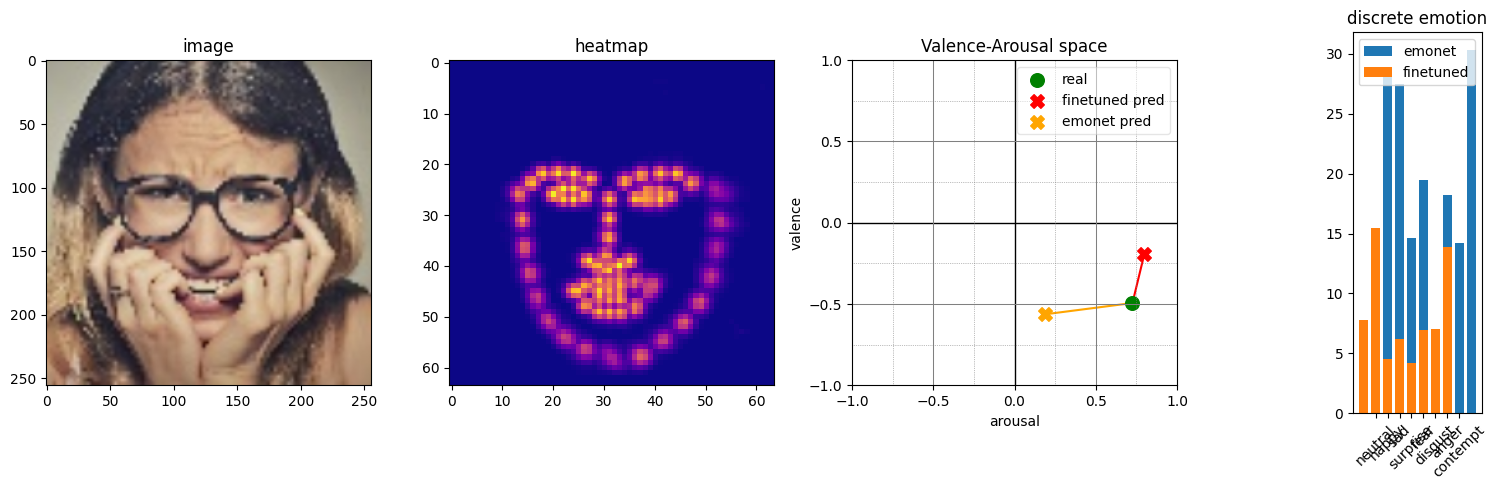

In [35]:
# 
torch.manual_seed(6)
for idx, (sample, labels) in enumerate(data_loader):
    # img = sample.permute(0, 2, 3, 1).numpy()[0]
    # exp_real, v_real, a_real = process_labels(labels)
    
    # # predict
    # with torch.no_grad():
    #     pred_emo = emonet(sample)
    #     pred_ft = emonet_ft(sample)
    # _, exp_vector_emo, v_pred_emo, a_pred_emo = process_model_output(pred_emo)
    # heatmap, exp_vector_ft, v_pred_ft, a_pred_ft = process_model_output(pred_ft)
    
    # # plot
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
    ax = ax.flatten()
    ax[0].set_title('image')
    ax[0].imshow(img)
    
    ax[1].set_title('heatmap')
    heatmap_comb = np.max(heatmap, axis=0)
    ax[1].imshow(heatmap_comb, cmap='plasma')
    
    ax[2].set_title('Valence-Arousal space')
    set_valence_arousal_space_plot(ax[2])
    # plot lines
    ax[2].plot([a_real, a_pred_emo], [v_real, v_pred_emo], c='red', zorder=0)
    ax[2].plot([a_real, a_pred_ft], [v_real, v_pred_ft], c='orange', zorder=0)
    # plot markers
    ax[2].scatter([a_real], [v_real], c='green', label='real', s=96)
    ax[2].scatter([a_pred_emo], [v_pred_emo], c='red', label='finetuned pred', marker='X', s=96)
    ax[2].scatter([a_pred_ft], [v_pred_ft], c='orange', label='emonet pred', marker='X', s=96)
    ax[2].legend(framealpha=0.5)
    
    ax[3].set_title('discrete emotion')
    # set_expression_plot(ax[3])
    ax[3].set_aspect('equal', adjustable='box')
    ax[3].set_xticks(range(8))
    ax[3].set_xticklabels(CANONICAL_8, rotation=45)
    exp_x = np.arange(8)
    wid = 1
    ax[3].bar(exp_x+wid, -exp_vector_emo, label='emonet')
    ax[3].bar(exp_x-wid, -exp_vector_ft, label='finetuned')
    ax[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    if idx+1 >= 1: break

In [ ]:
img = sample.permute(0, 2, 3, 1).numpy()[0]
print(img.shape)
# plt.imshow(img)
# plt.show()

heatmap_np = heatmap.permute(0, 1, 2, 3).numpy()[0]
heatmap_comb = np.max(heatmap_np, axis=0)
plt.imshow(heatmap_comb)
plt.show()